### Table of Contents
[Introduction](#intro)  
[Code Flow](#code)  
[Model Architecture](#model)  
[Results](#results)  
[Further/Possible Improvements](#improvements)  
[References](#reference)

### <a name='intro'>CNN+BiLSTM approach to Part-of-Speech(PoS) tagging to predict and restore punctuations to sentences</a>

The prevalent take on PoS problems have been to use BiLSTM or LSTM models due to their ability to capture and learn dependency information of sentences which are then used to make predictions.

This project intends to combine CNN with BiLSTM. Making use of CNNs' ability to capture word and morphological of sentences and forwarding them to the BiLSTM.

Outcome is to produce a hybrid model which outperforms a BiLSTM model.

#### <a name='code'>Code flow</a>

General code flow:

1. Import packages and dependencies required for the application
2. Load and process Ted Talks dataset to generate the corresponding labels  
3. Remove punctuations from dataset to remove bias  
4. Build vocabulary mappings of the dataset words and labels  
5. Tokenize dataset and labels based on mappings
6. Pad sequences and labels in dataset to maximum sequence length
7. One-hot encode labels as data is not ordinal
8. Split dataset into training and testing sets
9. Construct hybrid model
10. Feed training data into model with 30% of it used as validation
11. Load and process Glove embeddings to extract weight matrix based on unique words in dataset
12. Fit and train model with early stopping and checkpoint save of best results
13. Save image of model architecture
14. Delete current model and load saved model with best results
15. Retrieve a sample of testing data and make a prediction on it
16. Restore and print out results of prediction
17. Make predictions using testing set and construct a Confusion Matrix & Classification Report from it to evaluate model
18. Print out Precision, Recall and F1-Scores for testing set

#### Import required packages

In [1]:
# Set random seed
from numpy.random import seed
seed(50)
from tensorflow import set_random_seed
set_random_seed(50)

# Import required packages and dependencies
import io, json, keras, string, itertools, random, time, datetime, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from string import punctuation
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import Model, load_model
from keras.utils import to_categorical
from keras.initializers import glorot_uniform, random_uniform
from keras.layers import Activation
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.layers import Embedding, Conv1D, Flatten, Dense, Dropout, LSTM, Bidirectional, TimeDistributed, \
Dropout, Input, concatenate, Reshape
from keras import regularizers
from keras.utils import plot_model
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


#### Define model parameters

In [2]:
# Set model parameters
# Dimension of the embedding layer, must match that of the word vectors
embed_dim = 300

# Maximum sequence length, how long each sentence/sequence should be
max_seq_len = 128

# Dropout are
drop_prob = 0.3

# Number of filters for each CNN layer 
filter_sizes = [64,64,64]

# Kernel size for each CNN layer
kernels = [3,5,7]

# Weights and bias initialization for each CNN layer
kernel_weight = glorot_uniform()
bias = random_uniform()

# Regularization for each CNN layer
# kernel_reg = regularizers.l2(l=0.0001)
kernel_reg = None

# Embed trainable
trainable = True

# Number of hidden units for Dense layer
lstm_hidden = 1024

# Number of hidden units for BiLSTM layer
lstm_hidden_2 = 1024

# Learning rate for Adam optimizer
adam_lr = 0.001

# Batch size
batch_size = 64

# Number of epochs to train for
epochs = 30

# Portion of training data to be used for validation
valid_split = 0.3

# Define padding for CNN layers
cnn_padding = 'same'

# Define activation function for CNN layers
cnn_activation = 'relu'

# Define activation function for dense layer
dense_activation = 'relu'

# Define early stop parameters
monitor = 'val_loss'
patience = 2

# Define modelcheckpoint parameters
save_best_only=True

# Define padding type
seq_lab_padding = 'post'

#### Define miscellaneous settings 

In [3]:
# Dataset filename, change this variable to switch datasets
dataset_name = 'ted_data'

# train, validation dataset split ratio
split_rat = 0.8

#### Define custom functions

In [4]:
# Define custom functions
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    '''
    Description: 
        - Prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`

    Args:
        - cm: Confusion Matrix
        - classes: Names of classes
        - normalize: Whether to or to not normal values in Confusion Matrix
        - cmap: Plot color
    '''

    # Check if normalize is true or false
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("****Normalized confusion matrix:****")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    # Format axis and plot Confusion Matrix
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

def get_labels(seq):
    '''
    Description: 
        - Creates a sequence of labels based on the input sequence

    Args:
        - seq: Input sequence
    
    Returns:
        - labels_seq: Sequence labels
    '''
    
    labels_seq = []
    seq = seq.split()
    for i in range(len(seq)):
        if '...' in seq[i]:
            labels_seq.append('<3-dots>')
        elif ',' in seq[i]:
            labels_seq.append('<comma>')
        elif '.' in seq[i]:
            labels_seq.append('<period>')
        elif '?' in seq[i]:
            labels_seq.append('<question>')
        elif '!' in seq[i]:
            labels_seq.append('<exclaim>')
        else:
            labels_seq.append('<na>')
    return labels_seq

def process_dataset(dataset_name):
    '''
    Description:
        - Process the Ted Talks dataset
        - Processed data and labels are written to the processed folder
        
    Args:
        - dataset_name: Name of dataset file to be processed
    '''
    data = open('./data/processed/'+dataset_name, 'r', encoding='utf-8').read()
    
    # Convert all characters to lowercase
    data = data.lower()

    # Look-up table to remove punctuations from data
    table = str.maketrans('', '', punctuation)

    # Define and remove characters and bracketed actions
    replace = ['♫', '♪', '–', '…', '(applause)', '(laughter)']
    for i in range(len(replace)):
        data = data.replace(replace[i], ' ')

    # Split dataset by sentences
    data_split = data.split('\n')
    print('Pre number of '+dataset_name+' sentences: \t{}'.format(len(data_split)))
    print('\n')
    
    # Get longest sentence in dataset and its index
    print(max(enumerate(data_split), key=lambda x: len(x[1])))
    print('\n')
    print('Length of longest '+dataset_name+' sentence: \t{}'.format(len(max(data_split, key=len))))

    # Clean and split the longest sentence into multiple ones based on full-stops
    data_split[185073] = data_split[185073].replace(',', ', ')
    data_split[185073] = data_split[185073].replace('.', '.\n')
    long_sent = data_split[185073].split('\n')

    # Check number of sentences from chunking longest sentence
    print('Chunked longest '+dataset_name+' sentence: \t{}'.format(len(long_sent)))

    # Remove longest sentence at index 185703
    del data_split[185073]

    # Add chunked sentences back to dataset
    for x in long_sent:
        data_split.append(x)

    # Check length of dataset after addition
    print('Post number of '+dataset_name+' sentences: \t{}'.format(len(data_split)))
    print('\n')

    # Remove empty rows
    data_split = data_split[:238003]

    # Check last sentence of dataset
    print('Last Sentence of '+dataset_name+' dataset: {}'.format(data_split[-1]))
    print('\n')

    # Get corresponding labels for dataset
    process_labels = [get_labels(seq) for seq in data_split]
    process_labels = [' '.join(seq) for seq in process_labels]

    # Remove all punctuations from dataset
    sequences = [seq.translate(table) for seq in data_split]

    # Combined sentences back into a single piece for Counter
    combined_sequences = ' '.join(sequences)

    # Check if there are additional characters to remove
    print(Counter(combined_sequences))
    print('\n')

    # Get all words in the dataset
    words = combined_sequences.split()

    # Save inputs and labels for loading
    with open('./data/processed/'+dataset_name+'_processed_inputs', 'w', encoding='utf-8') as f:
        for x in sequences:
            f.write(x+'\n')
    with open('./data/processed/'+dataset_name+'_processed_labels', 'w', encoding='utf-8') as f:
        for x in process_labels:
            f.write(x+'\n')

    # Check number of sequences and labels
    print('Number of '+dataset_name+' sequences after processing: \t{}'.format(len(sequences)))
    print('Number of '+dataset_name+' labels after processing: \t{}'.format(len(process_labels)))
        
def load_processed_dataset(dataset_name):
    '''
    Description:
        - Loads processed dataset (Data and labels)
        - Dataset(s) must be present in the processed folder
        
    Args:
        - dataset_name: Name of data and labels file to be loaded
        
    Returns:
        - data_split: Processed data
        - y_labels: Processed labels
    '''
    # Load and process input/label data
    data = open('./data/processed/'+dataset_name+'_processed_inputs', 'r', encoding='utf-8').read()
    data = data.lower()
    data_split = data.split('\n')
    data_split = data_split[:-1]

    # Load processed labels
    y_labels = open('./data/processed/'+dataset_name+'_processed_labels', 'r', encoding='utf-8').read()
    y_labels = y_labels.split('\n')
    y_labels = y_labels[:-1]
    
    return data_split, y_labels    

def tokenize_data(data, labels, dataset_name):
    '''
    Description:
        - Tokenize and pad data/labels into integer sequences
        - Labels will further be one-hot encoded
        - Json files mapping unique words and labels will also be written into the processed folder
        
    Args:
        - data: Input data
        - labels: Labels
        - dataset_name: Name of dataset
        
    Returns:
        - unique_vocab: Number of unique words
        - no_classes: Number of unique labels
        - pad_seq: Tokenized and padded input data
        - encoded_labels: One-hot encoded labels sequences
        - vocab_to_int: Mapping of unique words to integers
        - label_to_int: Mapping of unique labels to integers
    '''
    # Join all words in data into one
    all_data = ' '.join(data)
    # Get all words
    words = all_data.split()
        
    # Build words vocab
    words_in_vocab = Counter(words)
    vocab = sorted(words_in_vocab, key=words_in_vocab.get, reverse=True)

    # Skip most common word
    vocab_to_int = {word: index for index, word in enumerate(vocab, 2)}
    vocab_to_int['<pad>'] = 0  # The special value used for padding
    vocab_to_int['<oov>'] = 1  # The special value used for OOVs
    
    # Write vocab dictionaries to file
    with open('./data/processed/'+dataset_name+'_vocabs.json', 'w', encoding='utf-8') as fv:
        json.dump(vocab_to_int, fv, indent=4)
    
    # Check number of unique words
    unique_vocab = len(vocab_to_int)
    print('Number of unique words:', unique_vocab)
    print('\n')
    
    # Tokenize input sequences
    seq_int = []
    for seq in data:
        seq_int.append([vocab_to_int[word] for word in seq.split()])

    # Pad input sequences
    pad_seq = pad_sequences(sequences=seq_int, maxlen=max_seq_len, padding=seq_lab_padding, value=0)

    # Check sample sequence
    print('Sample sequence:', data[-1])
    print('\n')
    print('Sample sequence:', pad_seq[-1])
    print('\n')
    
    # Join all labels into one
    all_labels = ' '.join(labels)
    # Get all labels
    labels_tag = all_labels.split()
    
    # Build labels vocab
    labels_in_vocab = Counter(labels_tag)
    labels_vocab = sorted(labels_in_vocab, key=labels_in_vocab.get, reverse=True)
    label_to_int = {t: i for i, t in enumerate(labels_vocab, 1)}
    label_to_int['<pad>'] = 0  # The special value used to padding #variable

    # Write labels dictionaries to file
    with open('./data/processed/'+dataset_name+'_labels.json', 'w', encoding='utf-8') as fl:
        json.dump(label_to_int, fl, indent=4)

    # Check label classes distribution
    no_classes = len(label_to_int)
    print('Class distribution:', Counter(labels_in_vocab))
    print('\n')

    # Check number of unique labels
    print('Number of unique labels:', no_classes)
    print(label_to_int)   
    print('\n')

    # Tokenize output labels
    lab_int = []
    for lab in labels:
        lab_int.append([label_to_int[word] for word in lab.split()])

    # Pad input labels
    pad_labels = pad_sequences(sequences=lab_int, maxlen=max_seq_len, padding=seq_lab_padding, value=0)
    encoded_labels = [to_categorical(i, num_classes=no_classes) for i in pad_labels]

    # Check sample label
    print('Sample label: \t{}'.format(pad_labels[-1]))
    print('\n')
    print('Encoded label: \t{}'.format(encoded_labels[-1]))
    print('\n')

    # Check that all sequences and labels are at max sequence length 
    assert len(pad_seq)==len(seq_int)
    assert len(pad_seq[0])==max_seq_len

    assert len(pad_labels)==len(lab_int)
    assert len(pad_labels[0])==max_seq_len
    print('Sequence and labels length check passed!')
    
    return unique_vocab, no_classes, pad_seq, encoded_labels, vocab_to_int, label_to_int

def split_data(pad_seq, encoded_labels, dataset_name):
    '''
    Description:
        - Splits tokenized data and labels into training and validation sets
        
    Args:
        - pad_seq: Toekenized input data sequences
        - encoded_labels: One-hot encoded labels sequences
        - dataset_name: Name of dataset
        
    Returns:
        - train_val_x: Training/validation input data
        - test_x: Testing input data
        - train_val_y: Training/validation labels
        - test_y: Testing labels
    '''
    # Ratio to split data and labels at
    split_index = int(split_rat*len(pad_seq))

    # Split data into training, validation, and test data (features and labels, x and y)
    train_val_x, test_x = pad_seq[:split_index], pad_seq[split_index:]
    train_val_y, test_y = encoded_labels[:split_index], encoded_labels[split_index:]

    # print out the shapes of your resultant feature data
    print('Training/Validation '+dataset_name+' Dataset: \t{}'.format(train_val_x.shape), len(train_val_y))
    print('Testing '+dataset_name+' Dataset: \t\t\t{}'.format(test_x.shape), len(test_y))
    
    return train_val_x, test_x, train_val_y, test_y

def set_callbacks(monitor, patience, dataset_name, save_best_only, batch_size):
    '''
    Descriptin:
        - Sets parameters for callbacks during training
        
    Args:
        - monitor: Metric to monitor during training for changes
        - patience: Number of epochs to keep training when there are no improvements
        - dataset_name: Name of dataset
        - save_best_only: Saves best training results
        - batch_size: Number of training data/labels per epoch
        
    Returns:
        - early_s: Early stopping callback
        - chkpt: Model checkpoint callback
        - tensor_b: Tensorboard callback
    '''
    early_s = EarlyStopping(monitor=monitor, patience=patience, verbose=1)
    chkpt = ModelCheckpoint(filepath='./models/'+dataset_name+'_model.h5',
                        monitor=monitor, save_best_only=save_best_only, verbose=1)
    tensor_b = TensorBoard(log_dir='./tf_logs/{}_model'.format(dataset_name, batch_size=batch_size, 
                        write_graph=False, histogram_freq=0))
    
    return early_s, chkpt, tensor_b

def create_model(max_seq_len, input_dim, output_dim, embed_weights, seq_len, trainable, drop_prob, lstm_hidden_2, 
                no_classes, model_type, **kwargs):
    '''
    Description: 
        - Constructs and compiles the CNN+BiLSTM model
    
    Args(They can be defined earlier at the top of the notebook):
        - max_seq_len: Maximum sequence length 
        - unique_vocab: Number of unique words
        - embed_dim: Embedding layer dimension, needs to match with that of Glove pre-trained
        - embed_matrix: Pre-trained weights extracted from Glove based on unique words
        - filter_sizes: Number of filters per CNN layer
        - kernels: Kernel sizes per CNN layer
        - kernel_weight: Weights initialization for CNN layers
        - bias: Bias initialization for CNN layers
        
    Return: 
        - model: Compiled model
    '''
    embed_input = Input(shape=(max_seq_len,))

    # Add embedding layer using weights from glove
    embed = Embedding(input_dim=unique_vocab, output_dim=embed_dim, weights=[embed_matrix], 
                      input_length=seq_len, trainable=trainable)(embed_input) #104910 * 300
    
    # Add dropout to embedding layer
    embed = Dropout(rate=drop_prob)(embed)
    
    if model_type == 'baseline':
        blstm_outputs = Bidirectional(LSTM(lstm_hidden_2, return_sequences=True))(embed)
        blstm_outputs = Dropout(rate=drop_prob)(blstm_outputs)
        output = TimeDistributed(Dense(no_classes, activation='softmax'))(blstm_outputs)
    else:        
        cnn_outputs = []
        for i in range(len(filter_sizes)):
            # Add conv1d layer
            out_i = Conv1D(filters=filter_sizes[i], kernel_initializer=kernel_weight, bias_initializer=bias, 
                              kernel_size=kernels[i], kernel_regularizer=kernel_reg, activation=cnn_activation, 
                              padding=cnn_padding, strides=1)(embed)
            cnn_outputs.append(out_i)

        cnn_outputs = concatenate(cnn_outputs, axis=-1)
        cnn_outputs = Dropout(rate=drop_prob)(cnn_outputs)
        cnn_outputs = Reshape((-1, np.sum(filter_sizes)))(cnn_outputs)

        dense = Dense(lstm_hidden, activation=dense_activation)(cnn_outputs)
        dense = Dropout(rate=drop_prob)(dense)

        blstm_outputs = Bidirectional(LSTM(lstm_hidden_2, return_sequences=True))(dense)

        blstm_outputs = Dropout(rate=drop_prob)(blstm_outputs)

        output = TimeDistributed(Dense(no_classes, activation='softmax'))(blstm_outputs)

    model = Model(inputs=[embed_input], outputs=[output])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(adam_lr), 
              metrics=['accuracy'])
    
    return model

def plot_train_hist(model):
    # Get training and validation accuracy histories
    train_acc = model.history['acc']
    val_acc = model.history['val_acc']

    # Create count of the number of epochs
    epoch_count = range(1, len(train_acc)+1)

    # Visualize accuracy history
    plt.plot(epoch_count, train_acc, 'r--')
    plt.plot(epoch_count, val_acc, 'b-')
    plt.legend(['Training Accuracy', 'Test Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy Score')
    plt.show()

def get_results(model, test_x, test_y, dataset_type): 
    precision = []
    recall = []
    f1 = []
    
    predict = model.predict(test_x)
    output_pred = [np.argmax(x, axis=1) for x in predict]
    output_pred = np.concatenate(output_pred, axis=0)

    y_ = [np.argmax(y, axis=1) for y in test_y]
    y_ = np.concatenate(y_, axis=0)
    
    cm = confusion_matrix(y_true=y_, y_pred=output_pred)
#     print('****Confusion Matrix:****')
#     print(cm)
#     print('\n')
    
    cr = classification_report(y_true=y_, y_pred=output_pred)
    print('****Classification Report****')
    print(cr)
    print('\n')
    
    overall = classification_report(y_true=y_, y_pred=output_pred, output_dict=True)
    
    # Define class names
    if dataset_type == 'mge':
        start = 1
        end = 6
        class_names = ['NA', 'Period', 'Comma', 'Question', 'Exclaim', '3-dots', 'Pad']
        
    else:
        class_names = ['Pad', 'NA', 'Comma', 'Period', 'Question', 'Exclaim', '3-Dots']        
        start = 2
        end = 7
        
    for i in range(start, end):
        precision.append(overall[str(i)]['precision'])
        recall.append(overall[str(i)]['recall'])
        f1.append(overall[str(i)]['f1-score'])
    
    print('****Average metrics over 3 main classes:****')
    print('Comma, Period, Question Precision:\t{:.3f}'.format(np.average(precision[:3])))
    print('Comma, Period, Question Recall:\t\t{:.3f}'.format(np.average(recall[:3])))
    print('Comma, Period, Question F1-Score:\t{:.3f}'.format(np.average(f1[:3])))
    print('\n')
    
    print('****Overall average metrics (Excludes padding and na):****')
    print('Overall Precision:\t{:.3f}'.format(np.average(precision)))
    print('Overall Recall:\t\t{:.3f}'.format(np.average(recall)))
    print('Overall F1-Score:\t{:.3f}'.format(np.average(f1)))        
    print('\n')
    
    plt.figure()
    plot_confusion_matrix(cm, classes=class_names, normalize=True, title=dataset_type+' Confusion Matrix')
    plt.show()
    
def make_prediction(model, test_seq, vocabs, labels, dataset_type):
    # Load a sample of test data
    test_data = test_seq

    # Restore tokenized test data back to normal sentence
    pred_x_seq = []
    for x in test_data:
        for value, index in vocabs.items():
            if x == index:
                pred_x_seq.append(value)

    # Get predicted output of test data (Make predictions)
    pred_expand = model.predict(np.expand_dims(test_data, axis=0))

    # Retrieve position of highest probability from predictions
    pred_y = []
    for y in pred_expand:
        pred_y.append(np.argmax(y, axis=1))
    print('Predictions Index:')
    print(pred_y)

    # Restore tokenized labels
    pred_y_seq = []
    for x in pred_y:
        for y in x:
            for value, index in labels.items():
                if y == index:
                    pred_y_seq.append(value)

    # Restore punctuations and capitalization                
    combined = []
    if dataset_type == 'mge':
        for i in range(len(pred_x_seq)):
            if pred_y_seq[i] == '2':
                combined.append(str(pred_x_seq[i])+',')
            elif pred_y_seq[i] == '1':
                combined.append(str(pred_x_seq[i])+'.')
            elif pred_y_seq[i] == '3':
                combined.append(str(pred_x_seq[i])+'?')
            elif pred_y_seq[i] == '4':
                combined.append(str(pred_x_seq[i])+'!')
            elif pred_y_seq[i] == '5':
                combined.append(str(pred_x_seq[i])+'...')
            else:
                combined.append(str(pred_x_seq[i]))
    else:
        for i in range(len(pred_x_seq)):
            if pred_y_seq[i] == '<comma>':
                combined.append(str(pred_x_seq[i])+',')
            elif pred_y_seq[i] == '<period>':
                combined.append(str(pred_x_seq[i])+'.')
            elif pred_y_seq[i] == '<question>':
                combined.append(str(pred_x_seq[i])+'?')
            elif pred_y_seq[i] == '<exclaim>':
                combined.append(str(pred_x_seq[i])+'!')
            elif pred_y_seq[i] == '<3-dots>':
                combined.append(str(pred_x_seq[i])+'...')
            else:
                combined.append(str(pred_x_seq[i]))

    for i in range(len(combined)):
        if '.' in combined[i]:
            combined[i+1] = combined[i+1].capitalize()
        elif combined[i] == 'i':
            combined[i] = combined[i].capitalize()
        else:
            continue

    # Join predicted words back into a sequence
    combined = ' '.join(combined)
    combined = combined.replace('<pad>', '')

    print('\n')
    print('Prediction sequence:')            
    print(' '.join(pred_x_seq))
    print('\n')
    print('Prediction output:')
    print(' '.join(pred_y_seq))
    print('\n')
    print('Combined prediction:')
    print(combined.capitalize().replace('ive', "I've"))

#### Load and process Ted Talks dataset. Splits data into training and validation sets

In [5]:
# Load custom dataset and labels (Applies to hybrid and baseline models)
process_dataset(dataset_name)
custom_data, custom_labels = load_processed_dataset(dataset_name)
unique_vocab, no_classes, pad_seq, encoded_labels, vocab_to_int, label_to_int = tokenize_data(data=custom_data, 
                                                                                              labels=custom_labels, 
                                                                                              dataset_name=dataset_name)

# Split custom dataset into training and validation
train_val_x, test_x, train_val_y, test_y = split_data(pad_seq, encoded_labels, dataset_name=dataset_name)

Pre number of ted_data sentences: 	237986


(185073, '  and this is more fun.so this last one is called "the sunshine kid."thank you very much for listening.old man sunshine was proud of his sun,and it brightened his day to see his little boy run,not because of what he’d done, nor the problems overcome,but that despite that his disposition remained a sunny one.it hadn’t always been like this.there’d been times when he’d tried to hide his brightness,you see, every star hits periods of hardship,it takes a brighter light to inspire them through the darkness.if we go back to when he was born in a nebula,we know that he never was thought of as regular,because he had a flair about him,to say the midas touch is wrongbut all he went near seemed to turn a little bronze,yes this sun was loved by some more than others,it was a case of joseph and his dreamcoat and his brothersbecause standing out from the crowd had its pros and its cons,and jealousy created enemies in those he outshonesuch as the 

#### Loda MGE dataset. Splits data into training and validation sets

In [6]:
# Load MGE dataset and labels
mge_data, mge_labels = load_processed_dataset('mge')
mge_unique_vocab, mge_no_classes, mge_pad_seq, mge_encoded_labels, mge_vocab_to_int, mge_label_to_int =  \
                                                tokenize_data(data=mge_data, labels=mge_labels, dataset_name='mge')

# Split MGE dataset into training and validation
mge_train_val_x, mge_test_x, mge_train_val_y, mge_test_y = split_data(mge_pad_seq, mge_encoded_labels, dataset_name='mge')

Number of unique words: 76055


Sample sequence: what do you miss of your old life


Sample sequence: [ 23  29   6 561   7  42 190 197   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]


Class distribution: Counter({'0': 5722741, '1': 582004, '2': 384732, '3': 109757, '4': 71598, '5': 30607})


Number of unique labels: 7
{'0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '<pad>': 0}


Sample label: 	[1 1 1 1 1 1 1 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 

#### Load and process Glove embeddings

In [7]:
# Load glove pre-trained vectors
glove_index = dict()
f = open('./data/embeddings/glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_index[word] = coefs
f.close()
print('{} word vectors'.format(len(glove_index)))

embed_matrix = np.zeros((unique_vocab, embed_dim))
for word, i in vocab_to_int.items():
    embedding_vector = glove_index.get(word)
    if embedding_vector is not None:
        embed_matrix[i] = embedding_vector

400000 word vectors


#### Create, fit and train hybrid model. Best trained model will be saved

In [8]:
hybrid = create_model(max_seq_len=max_seq_len, input_dim=unique_vocab, output_dim=embed_dim, embed_weights=embed_matrix, 
                seq_len=max_seq_len, trainable=trainable, drop_prob=drop_prob, lstm_hidden_2=lstm_hidden_2, 
                no_classes=no_classes, model_type='hybrid', lstm_hidden=lstm_hidden, filter_sizes=filter_sizes, 
                kernel_size=kernels, kernel_initializer=kernel_weight, bias_initializer=bias, 
                activation=cnn_activation, padding=cnn_padding)
hybrid.summary()
plot_model(hybrid, to_file='hybrid_model.png', show_shapes=True)

# Fit, train and evaluate model
early_s, chkpt, tensor_b = set_callbacks(monitor, patience, dataset_name, save_best_only, batch_size)

start = time.time()
hybrid = hybrid.fit(x=train_val_x, y=np.array(train_val_y), batch_size=batch_size, epochs=epochs, 
          validation_split=valid_split, shuffle=True, verbose=1, callbacks=[early_s, chkpt, tensor_b])

print('Time taken: {} seconds'.format(time.time()-start))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 128, 300)     31473000    input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 128, 64)      57664       dropout_1[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (

#### Create, fit and train baseline model. Best trained model will be saved

In [9]:
baseline = create_model(max_seq_len=max_seq_len, input_dim=unique_vocab, output_dim=embed_dim,
                embed_weights=embed_matrix, seq_len=max_seq_len, trainable=trainable, drop_prob=drop_prob, 
                lstm_hidden_2=lstm_hidden_2, no_classes=no_classes, model_type='baseline')
baseline.summary()
plot_model(baseline, to_file='baseline_model.png', show_shapes=True)

# Fit, train and evaluate model
early_s, chkpt, tensor_b = set_callbacks(monitor, patience, 'baseline', save_best_only, batch_size)

start = time.time()
baseline = baseline.fit(x=train_val_x, y=np.array(train_val_y), batch_size=batch_size, epochs=epochs, 
          validation_split=valid_split, shuffle=True, verbose=1, callbacks=[early_s, chkpt, tensor_b])
print('Time taken: {} seconds'.format(time.time()-start))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 128, 300)          31473000  
_________________________________________________________________
dropout_5 (Dropout)          (None, 128, 300)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128, 2048)         10854400  
_________________________________________________________________
dropout_6 (Dropout)          (None, 128, 2048)         0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 128, 7)            14343     
Total params: 42,341,743
Trainable params: 42,341,743
Non-trainable params: 0
________________________________________________________________

#### Create, fit and train MGE model. Best trained model will be saved

In [10]:
mge = create_model(max_seq_len=max_seq_len, input_dim=unique_vocab, output_dim=embed_dim, embed_weights=embed_matrix, 
                seq_len=max_seq_len, trainable=trainable, drop_prob=drop_prob, lstm_hidden_2=lstm_hidden_2, 
                no_classes=no_classes, model_type='mge', lstm_hidden=lstm_hidden, filter_sizes=filter_sizes, 
                kernel_size=kernels, kernel_initializer=kernel_weight, bias_initializer=bias, 
                activation=cnn_activation, padding=cnn_padding)
mge.summary()
plot_model(mge, to_file='mge_model.png', show_shapes=True)

# Fit, train and evaluate model
early_s, chkpt, tensor_b = set_callbacks(monitor, patience, 'mge', save_best_only, batch_size)

start = time.time()
mge = mge.fit(x=mge_train_val_x, y=np.array(mge_train_val_y), batch_size=batch_size, epochs=epochs, 
          validation_split=valid_split, shuffle=True, verbose=1, callbacks=[early_s, chkpt, tensor_b])
print('Time taken: {} seconds'.format(time.time()-start))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 128, 300)     31473000    input_3[0][0]                    
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 128, 300)     0           embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 128, 64)      57664       dropout_7[0][0]                  
__________________________________________________________________________________________________
conv1d_5 (

#### Plot training histories of each model

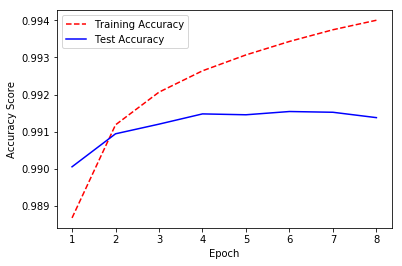

In [11]:
plot_train_hist(hybrid)

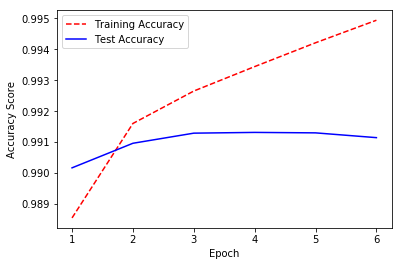

In [12]:
plot_train_hist(baseline)

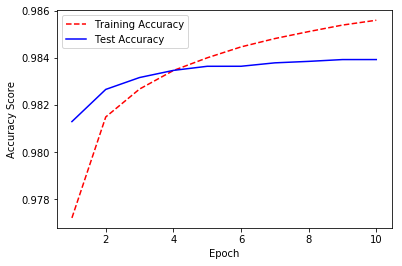

In [13]:
plot_train_hist(mge)

#### Delete created models

In [14]:
del hybrid, baseline, mge

#### Load best trained modeles

In [8]:
# Load best results for each model
hybrid = load_model('./models/'+dataset_name+'_model.h5')
baseline = load_model('./models/baseline_model.h5')
mge = load_model('./models/mge_model.h5')
print('All models loaded')

All models loaded


#### Show Classification Reports and Confusion Matrices

****Classification Report****
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4931231
           1       0.97      0.97      0.97   1014905
           2       0.64      0.61      0.63     76089
           3       0.91      0.86      0.89     64139
           4       0.66      0.61      0.63      5522
           5       0.13      0.05      0.08       566
           6       0.85      0.05      0.09       476

   micro avg       0.99      0.99      0.99   6092928
   macro avg       0.74      0.60      0.61   6092928
weighted avg       0.99      0.99      0.99   6092928



****Average metrics over 3 main classes:****
Comma, Period, Question Precision:	0.735
Comma, Period, Question Recall:		0.698
Comma, Period, Question F1-Score:	0.716


****Overall average metrics (Excludes padding and na):****
Overall Precision:	0.637
Overall Recall:		0.439
Overall F1-Score:	0.463


****Normalized confusion matrix:****


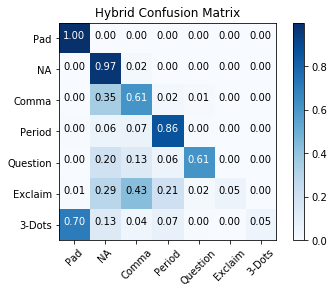

In [18]:
get_results(hybrid, test_x, test_y, 'Hybrid')

****Classification Report****
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4931231
           1       0.97      0.98      0.97   1014905
           2       0.64      0.59      0.61     76089
           3       0.93      0.84      0.88     64139
           4       0.67      0.62      0.64      5522
           5       0.26      0.06      0.10       566
           6       0.71      0.01      0.02       476

   micro avg       0.99      0.99      0.99   6092928
   macro avg       0.74      0.58      0.60   6092928
weighted avg       0.99      0.99      0.99   6092928



****Average metrics over 3 main classes:****
Comma, Period, Question Precision:	0.746
Comma, Period, Question Recall:		0.681
Comma, Period, Question F1-Score:	0.712


****Overall average metrics (Excludes padding and na):****
Overall Precision:	0.643
Overall Recall:		0.423
Overall F1-Score:	0.451


****Normalized confusion matrix:****


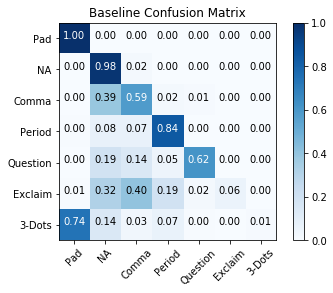

In [10]:
get_results(baseline, test_x, test_y, 'Baseline')

****Classification Report****
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5982527
           1       0.96      0.98      0.97   1075676
           2       0.66      0.74      0.70    108335
           3       0.58      0.45      0.51     73320
           4       0.77      0.66      0.71     21937
           5       0.42      0.18      0.26     13824
           6       0.53      0.07      0.12      6045

   micro avg       0.98      0.98      0.98   7281664
   macro avg       0.70      0.58      0.61   7281664
weighted avg       0.98      0.98      0.98   7281664



****Average metrics over 3 main classes:****
Comma, Period, Question Precision:	0.669
Comma, Period, Question Recall:		0.615
Comma, Period, Question F1-Score:	0.637


****Overall average metrics (Excludes padding and na):****
Overall Precision:	0.593
Overall Recall:		0.420
Overall F1-Score:	0.458


****Normalized confusion matrix:****


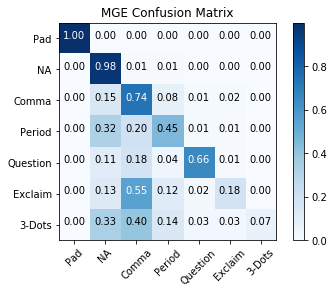

In [11]:
get_results(mge, mge_test_x, mge_test_y, 'MGE')

#### Make single predictions using testing data on each model

In [23]:
make_prediction(hybrid, test_x[1543], vocab_to_int, label_to_int, 'hybrid')

Predictions Index:
[array([1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)]


Prediction sequence:
in the 70s professor alexander comes along and he looks at this experiment and he noticed something <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <p

In [20]:
make_prediction(baseline, test_x[5515], vocab_to_int, label_to_int, 'baseline')

Predictions Index:
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)]


Prediction sequence:
whether through intuition or her attention to details that others failed to notice she became convinced that i could understand what was being said <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <p

In [21]:
make_prediction(mge, mge_test_x[2568], mge_vocab_to_int, mge_label_to_int, 'mge')

Predictions Index:
[array([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)]


Prediction sequence:
take the kick it is still twenty two to eighteen as the ball glides across the face of the post <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 

#### Load and process Ted Talks dataset to generate the corresponding labels

In [18]:
# # Read and load dataset
# data = open('./data/processed/'+dataset_name, 'r', encoding='utf-8').read()

# # Convert all characters to lowercase
# data = data.lower()

# # Look-up table to remove punctuations from data
# table = str.maketrans('', '', punctuation)

# # Define and remove characters and bracketed actions
# replace = ['♫', '♪', '–', '…', '(applause)', '(laughter)']
# for i in range(len(replace)):
#     data = data.replace(replace[i], ' ')

# # Split dataset by sentences
# data_split = data.split('\n')
# print('Pre number of sentences:', len(data_split))
# print('\n')
# # Get longest sentence in dataset and its index
# print(max(enumerate(data_split), key=lambda x: len(x[1])))
# print('\n')
# print('Length of longest sentence:', len(max(data_split, key=len)))

# # Clean and split the longest sentence into multiple ones based on full-stops
# data_split[185073] = data_split[185073].replace(',', ', ')
# data_split[185073] = data_split[185073].replace('.', '.\n')
# long_sent = data_split[185073].split('\n')

# # Check number of sentences from chunking longest sentence
# print('Chunked longest sentence:', len(long_sent))

# # Remove longest sentence at index 185703
# del data_split[185073]

# # Add chunked sentences back to dataset
# for x in long_sent:
#     data_split.append(x)

# # Check length of dataset after addition
# print('Post number of sentences:', len(data_split))
# print('\n')

# # Remove empty rows
# data_split = data_split[:238003]

# # Check last sentence of dataset
# print('Last Sentence', data_split[-1])
# print('\n')

# # Get corresponding labels for dataset
# process_labels = [get_labels(seq) for seq in data_split]
# process_labels = [' '.join(seq) for seq in process_labels]

# # Remove all punctuations from dataset
# sequences = [seq.translate(table) for seq in data_split]

# # Combined sentences back into a single piece for Counter
# combined_sequences = ' '.join(sequences)

# # Check if there are additional characters to remove
# print(Counter(combined_sequences))
# print('\n')
    
# # Get all words in the dataset
# words = combined_sequences.split()

# # Save inputs and labels for reference
# with open('./data/processed/processed_input', 'w', encoding='utf-8') as f:
#     for x in sequences:
#         f.write(x+'\n')
# with open('./data/processed/processed_labels', 'w', encoding='utf-8') as f:
#     for x in process_labels:
#         f.write(x+'\n')

# # Check number of sequences and labels
# print('Number of sequences: \t{}'.format(len(sequences)))
# print('Number of labels: \t{}'.format(len(process_labels)))

# # Load processed labels
# y_labels = open('./data/processed/processed_labels', 'r', encoding='utf-8').read()
# y_labels = y_labels.split('\n')
# y_labels = y_labels[:-1]
# all_labels = ' '.join(y_labels)

# # Get all labels in the dataset
# labels_tag = all_labels.split()

#### Build words and labels vocabularies and store them as json dictionaries

In [19]:
# # Build words vocab
# all_data = ' '.join(sequences)
# words = all_data.split()
# words_in_vocab = Counter(words)
# vocab = sorted(words_in_vocab, key=words_in_vocab.get, reverse=True)

# # Skip most common word
# vocab_to_int = {word: index for index, word in enumerate(vocab, 2)}
# vocab_to_int['<pad>'] = 0  # The special value used for padding
# vocab_to_int['<oov>'] = 1  # The special value used for OOVs

# # Check number of unique words
# unique_vocab = len(vocab_to_int)
# print('Number of unique words:', unique_vocab)
# print('\n')

# # Build labels vocab
# labels_in_vocab = Counter(labels_tag)
# labels_vocab = sorted(labels_in_vocab, key=labels_in_vocab.get, reverse=True)
# label_to_int = {t: i for i, t in enumerate(labels_vocab, 1)}
# label_to_int['<pad>'] = 0  # The special value used to padding #variable

# # Write vocab and label dictionaries to file
# with open('./vocabs.json', 'w', encoding='utf-8') as fv:
#     json.dump(vocab_to_int, fv, indent=4)
    
# with open('./labels.json', 'w', encoding='utf-8') as fl:
#     json.dump(label_to_int, fl, indent=4)
    
# # Check label classes distribution
# no_classes = len(label_to_int)
# print('Class distribution:', Counter(labels_in_vocab))
# print('\n')

# # Check number of unique labels
# print('Number of unique labels:', no_classes)
# print(label_to_int)

#### Tokenize the sequences and their corresponding labels. Pad each sequence and its labels to maximum length

In [20]:
# # Tokenize input sequences
# seq_int = []
# for seq in sequences:
#     seq_int.append([vocab_to_int[word] for word in seq.split()])

# # Pad input sequences
# pad_seq = pad_sequences(sequences=seq_int, maxlen=max_seq_len, padding=seq_lab_padding, value=0)

# # Check sample sequence
# print('Sample sequence:', sequences[-1])
# print('\n')
# print('Sample sequence:', pad_seq[-1])
# print('\n')

# # Tokenize output labels
# lab_int = []
# for lab in y_labels:
#     lab_int.append([label_to_int[word] for word in lab.split()])

# # Pad input labels
# pad_labels = pad_sequences(sequences=lab_int, maxlen=max_seq_len, padding=seq_lab_padding, value=0)
# encoded_labels = [to_categorical(i, num_classes=no_classes) for i in pad_labels]

# # Check sample label
# print('Sample label:', pad_labels[-1])
# print('\n')
# print('Encoded label', encoded_labels[-1])

# # Check max seq length
# print("Maximum sequence length: {}".format(max_seq_len))

# # Check that all sequences and labels are at max sequence length 
# assert len(pad_seq)==len(seq_int)
# assert len(pad_seq[0])==max_seq_len

# assert len(pad_labels)==len(lab_int)
# assert len(pad_labels[0])==max_seq_len
# print('Sequence and labels length check passed!')

#### Split dataset into training and testing sets

In [21]:
# # Split train and label dataset
# train_test_split_frac = 0.8
# split_index = int(0.8*len(pad_seq))

# # Split data into training, validation, and test data (features and labels, x and y)
# train_val_x, test_x = pad_seq[:split_index], pad_seq[split_index:]
# train_val_y, test_y = encoded_labels[:split_index], encoded_labels[split_index:]

# # print out the shapes of your resultant feature data
# print('Training/Validation Dataset: \t{}'.format(train_val_x.shape), len(train_val_y))
# print('Testing Dataset: \t\t{}'.format(test_x.shape), len(test_y))

#### Load and process Glove pretrained word vectors

In [22]:
# # Load glove pre-trained vectors
# glove_index = dict()
# f = open('./data/embeddings/glove.6B.300d.txt', encoding='utf-8')
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     glove_index[word] = coefs
# f.close()
# print('{} word vectors'.format(len(glove_index)))

# embed_matrix = np.zeros((unique_vocab, embed_dim))
# for word, i in vocab_to_int.items():
#     embedding_vector = glove_index.get(word)
#     if embedding_vector is not None:
#         embed_matrix[i] = embedding_vector

#### <a name='model'> Model Architecture </a>

The model consists of a few parts:

1. Embedding Layer:  
    * While it is possible to initialize and use a new empty embedding for the network to train and learn on, using a pre-trained embedding improves the model performance
    *  Matrix of weights extracted from the Glove pre-trained word vectors based on the number of unique words in the dataset
    
    
2. CNN Layers:
    * For each sequence in the dataset, a convolution window of x (Where x is the kernel size) is applied, capturing the morphological and feature information of x words at a time
    * 3 CNN layers each generating 128 filters with 3, 5 and 7 kernel sizes. 
    * Stride 1 is used and padding is applied (SAME) to keep the output length same as the input.
    * Outputs from the CNN layers are then concatenated and reshaped
    * They are then fed through a dense layer with ReLU activation to learn about their non-linear relationships 


3. BiLSTM Layer
    * Outputs from dense layer are then fed into a BiLSTM layer to learn about the structure and dependencies of the sequences
    *  A final Time Distributed dense layer is applied to make predictions on each word in the sequences
    
![Model Architecture](./images/model.png)

#### Function to create model

In [23]:
def cnn_lstm(max_seq_len, unique_vocab, embed_dim, embed_matrix, filter_sizes, kernels, kernel_weight, bias):
    '''
    Description: 
        - Constructs and compiles the CNN+BiLSTM model
    
    Args(They can be defined earlier at the top of the notebook):
        - max_seq_len: Maximum sequence length 
        - unique_vocab: Number of unique words
        - embed_dim: Embedding layer dimension, needs to match with that of Glove pre-trained
        - embed_matrix: Pre-trained weights extracted from Glove based on unique words
        - filter_sizes: Number of filters per CNN layer
        - kernels: Kernel sizes per CNN layer
        - kernel_weight: Weights initialization for CNN layers
        - bias: Bias initialization for CNN layers
        
    Return: 
        - Compiled model
    '''
    embed_input = Input(shape=(max_seq_len,))

    # Add embedding layer using weights from glove
    embed = Embedding(input_dim=unique_vocab, output_dim=embed_dim, weights=[embed_matrix], 
                        input_length=max_seq_len, trainable=True)(embed_input) #104910 * 300
    
    embed = Dropout(rate=drop_prob)(embed)

    cnn_outputs = []
    for i in range(len(filter_sizes)):
        # Add conv1d layer
        out_i = Conv1D(filters=filter_sizes[i], kernel_initializer=kernel_weight, bias_initializer=bias, 
                          kernel_size=kernels[i], kernel_regularizer=None, activation=cnn_activation, 
                          padding=cnn_padding, strides=1)(embed)
#         out_i = BatchNormalization()(out_i)
        cnn_outputs.append(out_i)

    cnn_outputs = concatenate(cnn_outputs, axis=-1)
    cnn_outputs = Dropout(rate=drop_prob)(cnn_outputs)
    cnn_outputs = Reshape((-1, np.sum(filter_sizes)))(cnn_outputs)
    
    dense = Dense(lstm_hidden, activation=dense_activation)(cnn_outputs)
    dense = Dropout(rate=drop_prob)(dense)
    
    blstm_outputs = Bidirectional(LSTM(lstm_hidden_2, return_sequences=True))(dense)
    
    blstm_outputs = Dropout(rate=drop_prob)(blstm_outputs)
    
    output = TimeDistributed(Dense(no_classes, activation='softmax'))(blstm_outputs)

    model = Model(inputs=[embed_input], outputs=[output])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(adam_lr), 
              metrics=['accuracy'])
    
    return model

#### Initialize and train model

In [24]:
# # Model code
# model = cnn_lstm(max_seq_len=max_seq_len, unique_vocab=unique_vocab, embed_dim=embed_dim,
#                 embed_matrix=embed_matrix, filter_sizes=filter_sizes, kernels=kernels,
#                  kernel_weight=kernel_weight, bias=bias)

# # Summarize model
# model.summary()

# # Fit, train and evaluate model
# start = time.time()
# model.fit(x=train_val_x, y=np.array(train_val_y), batch_size=batch_size, 
#           epochs=epochs, validation_split=valid_split, shuffle=True, verbose=1, callbacks=[tensor_b, early_s, chkpt])
# print('Time taken: {} seconds'.format(time.time()-start))

#### Save model architecture and model

In [25]:
# plot_model(model, to_file='model.png', show_shapes=True)

In [26]:
# # Delete previous model and load model with best results
# del model
# model = load_model('./cnn_lstm_model.h5')

#### Load a sample test data, make a prediction from it and print the results

In [27]:
# # Load a sample of test data
# test_data = test_x[11111]

# # Restore tokenized test data back to normal sentence
# pred_x_seq = []
# for x in test_data:
#     for value, index in vocab_to_int.items():
#         if x == index:
#             pred_x_seq.append(value)

# # Get predicted output of test data (Make predictions)
# pred_expand = model.predict(np.expand_dims(test_data, axis=0))

# # Retrieve position of highest probability from predictions
# pred_y = []
# for y in pred_expand:
#     pred_y.append(np.argmax(y, axis=1))
# print('Predictions Index:')
# print(pred_y)

# # Restore tokenized labels
# pred_y_seq = []
# for x in pred_y:
#     for y in x:
#         for value, index in label_to_int.items():
#             if y == index:
#                 pred_y_seq.append(value)

# # Restore punctuations and capitalization                
# combined = []
# for i in range(len(pred_x_seq)):
#     if pred_y_seq[i] == '<comma>':
#         combined.append(str(pred_x_seq[i])+',')
#     elif pred_y_seq[i] == '<period>':
#         combined.append(str(pred_x_seq[i])+'.')
#     elif pred_y_seq[i] == '<question>':
#         combined.append(str(pred_x_seq[i])+'?')
#     elif pred_y_seq[i] == '<exclaim>':
#         combined.append(str(pred_x_seq[i])+'!')
#     elif pred_y_seq[i] == '<3-dots>':
#         combined.append(str(pred_x_seq[i])+'...')
#     else:
#         combined.append(str(pred_x_seq[i]))

# for i in range(len(combined)):
#     if '.' in combined[i]:
#         combined[i+1] = combined[i+1].capitalize()
#     elif combined[i] == 'i':
#         combined[i] = combined[i].capitalize()
#     else:
#         continue

# # Join predicted words back into a sequence
# combined = ' '.join(combined)
# combined = combined.replace('<pad>', '')

# print('\n')
# print('Prediction sequence:')            
# print(' '.join(pred_x_seq))
# print('\n')
# print('Prediction output:')
# print(' '.join(pred_y_seq))
# print('\n')
# print('Combined prediction:')
# print(combined.capitalize().replace('ive', "I've"))

#### <a name='results'> Results </a>
Barring the Pad and NA classes which are not our targets, the below can be observed from the Classifcation Report and Confusion Matrix:

* Model performs decently on predicting Commas, Periods and Question Marks achieving 61%, 89% and, 63% F1-Score respectively
* Predictions for Exclaimation Marks and 3 Consecutive Dots performed the worst at 7% and 9% F1-Score respectively
* The difference in performance could possibly be due to class imbalances resulting in the model "viewing" insufficient exmaples to make more accurate predictions 

##### Ted Talks vs Baseline vs MGE
![Comparison](./images/comparision2.jpg)

When compared 

##### Parameters, model explorations and improvements

Mutiple model parameters combinations have been attempted to check on their performance. Their results can be viewed [here](https://docs.google.com/spreadsheets/d/1FguxMPOCumn6J5Zgo7-S6yhNAFMkLuPKATyPfGzwkq8/edit#gid=301828972)

The following model configurations have also been attempted:
* Increasing the amount of CNN layers to 4: No substantial improvements
* Concatenating the outputs of the CNN layers instead of passing them through each layer: Model performance improves

#### Create Confusion Matrix and Classification Report to check model performance

In [28]:
# # Create confusion matrix and classification report
# for_report = model.predict(test_x)
# out_pred = [np.argmax(x, axis=1) for x in for_report]
# out_pred = np.concatenate(out_pred, axis=0)

# y_ = [np.argmax(x, axis=1) for x in test_y]
# y_ = np.concatenate(y_, axis=0)

# cm = confusion_matrix(y_true=y_, y_pred=out_pred)
# print(cm)

# cr = classification_report(y_true=y_, y_pred=out_pred)
# print(cr)

# overall = classification_report(y_true=y_, y_pred=out_pred, output_dict=True)

# plt.figure()
# plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized Confusion Matrix')
# plt.show()

#### Check the average Precision, Recall and, F1-Score of different classes

In [29]:
# # comma, period, question, exclaim, 3-dots
# precision = []
# recall = []
# f1 = []

# for i in range(2, 7):
#     precision.append(overall[str(i)]['precision'])
#     recall.append(overall[str(i)]['recall'])
#     f1.append(overall[str(i)]['f1-score'])

# print('Comma, Period, Question Precision:\t{:.3f}'.format(np.average(precision[:3])))
# print('Comma, Period, Question Recall:\t\t{:.3f}'.format(np.average(recall[:3])))
# print('Comma, Period, Question F1-Score:\t{:.3f}'.format(np.average(f1[:3])))
# print('\n')

# print('Overall Precision:\t{:.3f}'.format(np.average(precision)))
# print('Overall Recall:\t\t{:.3f}'.format(np.average(recall)))
# print('Overall F1-Score:\t{:.3f}'.format(np.average(f1)))

#### <a name='improvements'> Further/Possible Improvements </a>
* Increase dataset size and monitor if there are improvements
* Add attention mechanism to track critical outputs

#### <a name='reference'> References </a>

* [Bitbucket Repo]()
* [How to build a PoS tagger](https://nlpforhackers.io/lstm-pos-tagger-keras/)
* [Keras pre-trained word embeddings](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)
* [Keras Documentation](https://keras.io/)